In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import math
from sklearn.model_selection import train_test_split
import pickle

### 1. Load Data

In [4]:
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_sample = pd.read_csv("sample_submission.csv")

### 2. Exploratory data analysis

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [8]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             625134 non-null  object
 1   trip_duration  625134 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ MB


#### 3. Data preparation

3.1 Trip duration clean-up

In [9]:
m = np.mean(df_train['trip_duration'])
s = np.std(df_train['trip_duration'])
df_train = df_train[df_train['trip_duration'] <= m + 2*s]
df_train = df_train[df_train['trip_duration'] >= m - 2*s]

3.2 Latitude and longitude clean-up

In [10]:
df_train = df_train[df_train['pickup_longitude'] <= -73.75]
df_train = df_train[df_train['pickup_longitude'] >= -74.03]
df_train = df_train[df_train['pickup_latitude'] <= 40.85]
df_train = df_train[df_train['pickup_latitude'] >= 40.63]
df_train = df_train[df_train['dropoff_longitude'] <= -73.75]
df_train = df_train[df_train['dropoff_longitude'] >= -74.03]
df_train= df_train[df_train['dropoff_latitude'] <= 40.85]
df_train = df_train[df_train['dropoff_latitude'] >= 40.63]

3.3 Date Clean-up

In [11]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)

df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.date

df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)

In [12]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26


In [13]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N


In [14]:
#Convert character variables to numeric 
f = lambda x: 0 if x == 'N' else 1

df_train["store_and_fwd_flag"] =df_train["store_and_fwd_flag"].apply(lambda x: f(x))

3 Data Visualisation and Analysis

3.1 Initial Analysis

##### Histogram plot of Trip Duration

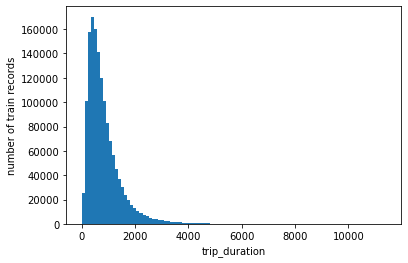

In [15]:
plt.hist(df_train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

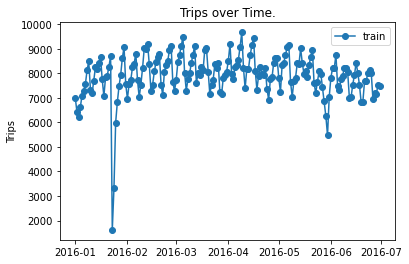

In [16]:
plt.plot(df_train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

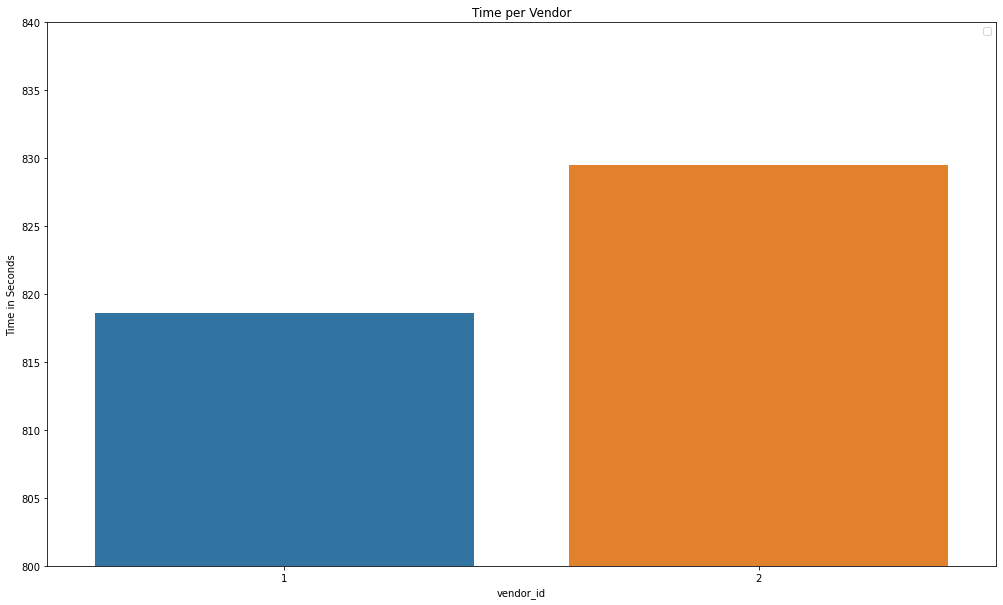

In [17]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = df_train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

In [18]:
df_train.groupby('passenger_count').size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

In [19]:
df_test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

#### 3.2 Coordinate Mapping

##### 3.2.1 Pick Up Location

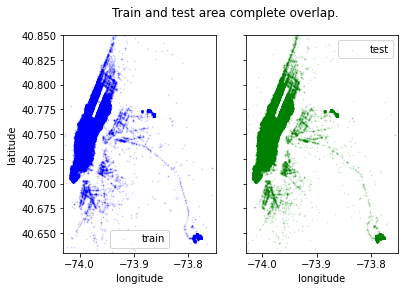

In [20]:
city_long_border = (-74.03, -73.75) # nyc longtitude border
city_lat_border = (40.63, 40.85) # nyc latitude border
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:100000], df_train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df_test['pickup_longitude'].values[:100000], df_test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

##### 3.2.2  Distance and directionality

In [21]:
#def get_distance(source_lat, source_long, dest_lat, dest_long):
    # Returns the distance in Miles between the source and the destination.
    
    #distance = geodesic((source_lat, source_long), 
                        ##(dest_lat, dest_long)).km
    #return distance



In [22]:
#latitude and longitude differences 
df_train["latitude_difference"] = df_train["dropoff_latitude"] - df_train["pickup_latitude"]
df_train["longitude_difference"] = df_train["dropoff_longitude"] - df_train["pickup_longitude"]

In [23]:
#Convert trip distance from longitude and latitude differences to Manhattan distance.
df_train["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_train["latitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(df_train["latitude_difference"]) * np.pi / 180) / 2)))))) + \
                                     abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_train["longitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(df_train["longitude_difference"]) * np.pi / 180) / 2)))))))

In [24]:
df_train.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,latitude_difference,longitude_difference,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,2016-03-14,-0.002,0.018,1.372
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,2016-06-12,-0.007,-0.019,1.829
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,2016-01-19,-0.054,-0.026,5.538
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,2016-04-06,-0.013,-0.002,1.070
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,2016-03-26,-0.011,0.000,0.747


#### 4. Data extraction & featuring

In [25]:
# Extracting variables, like month, date, etc.
df_train["pickup_month"] = df_train["pickup_datetime"].dt.month
df_train["pickup_day"] = df_train["pickup_datetime"].dt.day
df_train["pickup_weekday"] = df_train["pickup_datetime"].dt.weekday 
#sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday_name
df_train["pickup_hour"] = df_train["pickup_datetime"].dt.hour
df_train["pickup_minute"] = df_train["pickup_datetime"].dt.minute

#### Both train and test data sets have 6 months, so months are ready for dummy variables (i.e. encoding)

In [26]:
df_train["trip_duration"] = df_train["trip_duration"].apply(lambda x: round(x/60))

#### 5. Data enrichment

#### 6. Modelling

In [27]:
X = df_train.drop(["trip_duration", "id", "vendor_id", "pickup_datetime","pickup_date", "dropoff_datetime"], axis=1)
y = df_train["trip_duration"]

In [28]:
#Split the data into training, test, and valdiation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)


In [29]:
#Define evaluation metric
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [30]:
#Define train and validation sets
dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
dval = xgb.DMatrix(X_val, np.log(y_val+1))

watchlist = [(dtrain, 'train'), (dval, 'valid')]

In [31]:
#XGBoost parameters 
params = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.05,
    'max_depth':          14,
    'subsample':          0.9,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1,
    'feval':              'rmsle'
}

In [32]:
#Train model
gbm = xgb.train(params,
                dtrain,
                num_boost_round = 2000,
                evals = watchlist,
                verbose_eval = True
                )

[11:32:12] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:32:12] WARNING: ..\src\learner.cc:541: 
Parameters: { feval, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:1.98136	valid-rmse:1.97961
[1]	train-rmse:1.88544	valid-rmse:1.88382
[2]	train-rmse:1.79451	valid-rmse:1.79304
[3]	train-rmse:1.71106	valid-rmse:1.70974
[4]	train-rmse:1.62934	valid-rmse:1.62813
[5]	train-rmse:1.55146	valid-rmse:1.55039
[6]	train-rmse:1.47814	valid-rmse:1.47713
[7]	train-rmse:1.40829	valid-rmse:1.40749
[8]	train-rmse:1.34225	valid-rmse:1.34167
[9]	train-rmse:1.28100	valid-rmse:1.28055
[10]	train-rmse:1.22271	valid-rmse:1.22241
[11]	train-rmse:1.16609	valid-rmse:1.16604
[12]	t

In [33]:
#Test predictions
pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1

In [34]:
#Use mean absolute error to get a basic estimate of the error
mae = (abs(pred - y_test)).mean()
mae

2.6376781463623047

In [35]:
#Take a look at feature importance
feature_scores = gbm.get_fscore()
feature_scores

{'trip_distance': 472400,
 'pickup_latitude': 766225,
 'pickup_minute': 394089,
 'pickup_weekday': 206787,
 'dropoff_longitude': 684523,
 'latitude_difference': 549151,
 'pickup_day': 358457,
 'passenger_count': 234271,
 'store_and_fwd_flag': 5593,
 'pickup_hour': 318672,
 'dropoff_latitude': 631772,
 'pickup_month': 201668,
 'pickup_longitude': 801160,
 'longitude_difference': 510236}

In [36]:
filename = "xgb_model.sav"
pickle.dump(gbm, open(filename, 'wb'))

In [37]:
pred.flatten()

array([ 8.4303255, 16.695436 ,  7.3920193, ...,  5.249577 ,  4.251596 ,
        4.155295 ], dtype=float32)

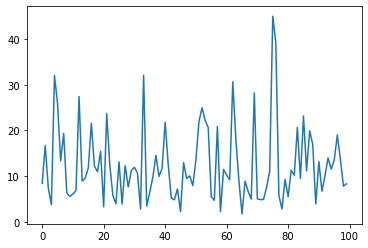

In [38]:
plt.plot(pred[0:100])
plt.show()

In [39]:
y

0           8
1          11
2          35
3           7
4           7
           ..
1458639    13
1458640    11
1458641    13
1458642     6
1458643     3
Name: trip_duration, Length: 1437128, dtype: int64

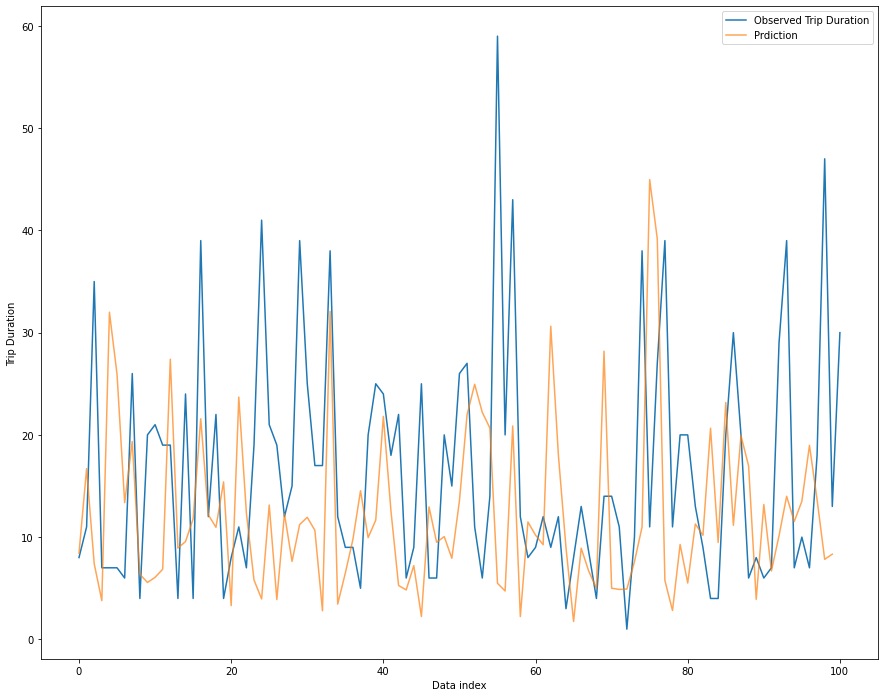

In [40]:
pred_frame= pd.DataFrame(data=pred)
plt.figure(figsize=(15,12))
ax = y.iloc[0:100].plot(label='Observed Trip Duration')
plt.plot(pred_frame[0].iloc[0:100],label='Prdiction',alpha=.7)

ax.set_xlabel('Data index')
ax.set_ylabel('Trip Duration')
plt.legend()
plt.show()


#### Model Evaluation

In [42]:
df_test = pd.read_csv("test.csv")

In [43]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N


In [44]:
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.date

In [45]:
df_test["latitude_difference"] = df_test["dropoff_latitude"] - df_test["pickup_latitude"]
df_test["longitude_difference"] = df_test["dropoff_longitude"] - df_test["pickup_longitude"]
df_test["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_test["latitude_difference"]) * np.pi / 180) / 2))),
   np.sqrt(1 - (np.square(np.sin((abs(df_test["latitude_difference"]) * np.pi / 180) / 2)))))) + \
abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_test["longitude_difference"]) * np.pi / 180) / 2))),
   np.sqrt(1 - (np.square(np.sin((abs(df_test["longitude_difference"]) * np.pi / 180) / 2)))))))

In [46]:
df_test["pickup_month"] = df_test["pickup_datetime"].dt.month
df_test["pickup_day"] = df_test["pickup_datetime"].dt.day
df_test["pickup_weekday"] = df_test["pickup_datetime"].dt.weekday 
#sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday_name
df_test["pickup_hour"] = df_test["pickup_datetime"].dt.hour
df_test["pickup_minute"] = df_test["pickup_datetime"].dt.minute

In [47]:
f = lambda x: 0 if x == 'N' else 1

df_test["store_and_fwd_flag"] =df_test["store_and_fwd_flag"].apply(lambda x: f(x))

In [48]:
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)

In [49]:
df_test = df_test.drop(['pickup_datetime','pickup_date'],axis = 1)

In [50]:
df_test = df_test.drop(['id','vendor_id'],axis = 1)

In [51]:
df_test["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_test["latitude_difference"]) * np.pi / 180) / 2))),
   np.sqrt(1 - (np.square(np.sin((abs(df_test["latitude_difference"]) * np.pi / 180) / 2)))))) + \
abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(df_test["longitude_difference"]) * np.pi / 180) / 2))),
   np.sqrt(1 - (np.square(np.sin((abs(df_test["longitude_difference"]) * np.pi / 180) / 2)))))))

In [52]:
df_test = xgb.DMatrix(df_test)
pred = gbm.predict(df_test)
pred = np.exp(pred) - 1

In [53]:
pred

array([13.104312, 10.45952 ,  7.905959, ..., 26.406986, 25.18115 ,
       20.13534 ], dtype=float32)